## Conspiracy Theory Shit
Is NorESM2 not running COSP correctly?

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims
    )

from classes import SatComp_Metric, CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
cosp_dir = 'satcomp/'
plain_dir = 'mnth15runs/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [14]:
files = os.listdir(plain_dir)
files.sort()
files

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

In [15]:
cosp_case = "20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2"
plain_case = "20200501_180255_singleparam_cam61_arctic2_wbf_0.2_inp_0.2"

In [20]:
cosp_da = xr.open_dataset("%s%s/atm/hist/%s.cam.h0.2009-03.nc" % (cosp_dir, cosp_case, cosp_case))
plain_da = xr.open_dataset("%s%s/atm/hist/%s.cam.h0.2009-03.nc" % (plain_dir, plain_case, plain_case))

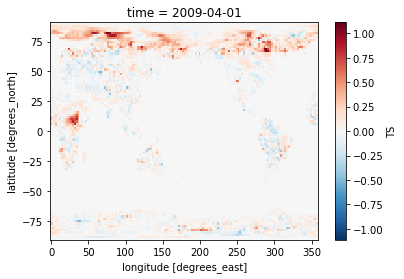

In [28]:
(plain_da['TS'][0,:,:] - cosp_da['TS'][0,:,:]).plot()

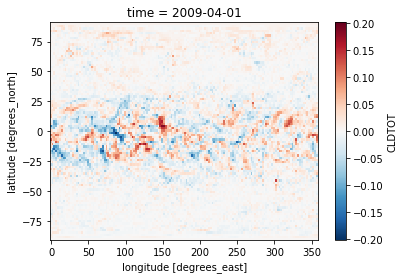

In [30]:
(plain_da['CLDTOT'][0,:,:] - cosp_da['CLDTOT'][0,:,:]).plot()

In [29]:
plain_da

<xarray.Dataset>
Dimensions:               (ilev: 33, isotherms_mpc: 9, lat: 96, lev: 32, lon: 144, nbnd: 2, time: 1, zlon: 1)
Coordinates:
  * lat                   (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * zlon                  (zlon) float64 0.0
  * lon                   (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lev                   (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev                  (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * isotherms_mpc         (isotherms_mpc) float64 233.1 238.1 ... 268.1 273.1
  * time                  (time) datetime64[ns] 2009-04-01
Dimensions without coordinates: nbnd
Data variables:
    zlon_bnds             (zlon, nbnd) float64 ...
    gw                    (lat) float64 ...
    hyam                  (lev) float64 ...
    hybm                  (lev) float64 ...
    P0                    float64 ...
    hyai                  (ilev) float64 ...
    hybi                  (ilev) float64 ...
    isotherms_mpc_bounds  (isotherms_mpc, nbnd) float64 ...
    date                  (time) int32 ...
    datesec               (time) int32 ...
    time_bnds             (time, nbnd) datetime64[ns] ...
    date_written          (time) |S8 ...
    time_written          (time) |S8 ...
    ndbase                int32 ...
    nsbase                int32 ...
    nbdate                int32 ...
    nbsec                 int32 ...
    mdt                   int32 ...
    ndcur                 (time) int32 ...
    nscur                 (time) int32 ...
    co2vmr                (time) float64 ...
    ch4vmr                (time) float64 ...
    n2ovmr                (time) float64 ...
    f11vmr                (time) float64 ...
    f12vmr                (time) float64 ...
    sol_tsi               (time) float64 ...
    nsteph                (time) int32 ...
    ABSVIS                (time, lat, lon) float32 ...
    ABSVVOLC              (time, lat, lon) float32 ...
    ACTNI                 (time, lat, lon) float32 ...
    ACTNL                 (time, lat, lon) float32 ...
    ACTNL_B               (time, lat, lon) float32 ...
    ACTREI                (time, lat, lon) float32 ...
    ACTREL                (time, lat, lon) float32 ...
    ADRAIN                (time, lev, lat, lon) float32 ...
    ADSNOW                (time, lev, lat, lon) float32 ...
    AEROD_v               (time, lat, lon) float32 ...
    ANRAIN                (time, lev, lat, lon) float32 ...
    ANSNOW                (time, lev, lat, lon) float32 ...
    AODVVOLC              (time, lat, lon) float32 ...
    AOD_VIS               (time, lat, lon) float32 ...
    AQRAIN                (time, lev, lat, lon) float32 ...
    AQSNOW                (time, lev, lat, lon) float32 ...
    AREI                  (time, lev, lat, lon) float32 ...
    AREL                  (time, lev, lat, lon) float32 ...
    ASYMMVIS              (time, lev, lat, lon) float32 ...
    AWNC                  (time, lev, lat, lon) float32 ...
    AWNI                  (time, lev, lat, lon) float32 ...
    BCFREZCNT             (time, lev, lat, lon) float32 ...
    BCFREZDEP             (time, lev, lat, lon) float32 ...
    BCFREZIMM             (time, lev, lat, lon) float32 ...
    BCNICNT               (time, lev, lat, lon) float32 ...
    BCNIDEP               (time, lev, lat, lon) float32 ...
    BCNIIMM               (time, lev, lat, lon) float32 ...
    BC_A                  (time, lev, lat, lon) float32 ...
    BC_AC                 (time, lev, lat, lon) float32 ...
    BC_AC_OCW             (time, lev, lat, lon) float32 ...
    BC_AC_SRF             (time, lat, lon) float32 ...
    BC_AI                 (time, lev, lat, lon) float32 ...
    BC_AI_OCW             (time, lev, lat, lon) float32 ...
    BC_AI_SRF             (time, lat, lon) float32 ...
    BC_AX                 (time, lev, lat, lon) float32 ...
    BC_AX_CLXF            (time, lat, lon) float32 ...
    BC_AX_CMXF            (time, l